In [1]:
from leduc_poker import LeducPoker
from one_card_poker import OneCardPoker

from cfr_game import CFRGame
from example_strategy import constant_action_strategy
from example_strategy import dirichlet_random_strategy
from example_strategy import uniformly_random_strategy
from best_response import compute_exploitability
from cfr import *

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
% config InlineBackend.figure_format = 'svg'

In [3]:
game = OneCardPoker.create_game(13)
# game.print_tree(only_leaves=True)

In [4]:
# The strategy that always folds.
strategy_folds = constant_action_strategy(game, 1, 0)
strategy_folds.update(constant_action_strategy(game, 2, 0))
exploitability_folds = compute_exploitability(game, strategy_folds)
print("Exploitability of always folding: {:.4f}".format(exploitability_folds))

Exploitability of always folding: 0.0000


In [5]:
# The strategy that always calls
strategy_calls = constant_action_strategy(game, 1, 1)
strategy_calls.update(constant_action_strategy(game, 2, 1))
exploitability_calls = compute_exploitability(game, strategy_calls)
print("Exploitability of always calling: {:.4f}".format(exploitability_calls))

Exploitability of always calling: 1.0000


In [6]:
# The strategy that always raises.
strategy_raises = constant_action_strategy(game, 1, 2)
strategy_raises.update(constant_action_strategy(game, 2, 2))
exploitability_raises = compute_exploitability(game, strategy_raises)
print("Exploitability of always raising: {:.4f}".format(exploitability_raises))

Exploitability of always raising: 0.5481


In [7]:
# A randomly chosen strategy
strategy_random = dirichlet_random_strategy(game, 1)
strategy_random.update(dirichlet_random_strategy(game, 2))
exploitability_random = compute_exploitability(game, strategy_random)
print("Exploitability of the random strategy: {:.4f}".format(exploitability_random))

Exploitability of the random strategy: 0.5537


In [8]:
# A strategy that chooses actions uniformly at random.
strategy_uniformly_random = uniformly_random_strategy(game, 1)
strategy_uniformly_random.update(uniformly_random_strategy(game, 2))
exploitability_uniformly_random = compute_exploitability(game, strategy_uniformly_random)
print("Exploitability of the uniformly random strategy: {:.4f}".format(exploitability_uniformly_random))

Exploitability of the uniformly random strategy: 0.5481


In [25]:
# Use CFR on Leduc
print("Now running CFR ...")

game = CFRGame(OneCardPoker.create_game(100))
cfr_exp_list = []
cfr_exp_avg_list = []

num_iters = 2000

# regrets is a dictionary where the keys are the information sets and values
# are dictionaries from actions available in that information set to the
# counterfactual regret for not playing that action in that information set.
# Since information sets encode the player, we only require one dictionary.
regrets = dict()

# Similarly, action_counts is a dictionary with keys the information sets
# and values dictionaries from actions to action counts.
action_counts = dict()

# Strategy_t holds the strategy at time t; similarly strategy_t_1 holds the
# strategy at time t + 1.
strategy_t = dict()
strategy_t_1 = dict()

average_strategy = None

# Each information set is uniquely identified with an action tuple.
for t in tqdm(range(num_iters)):
    for i in [1, 2]:
        cfr_recursive(game, game.game.root, i, t, 1.0, 1.0, regrets,
                      action_counts, strategy_t, strategy_t_1)

    average_strategy = compute_average_strategy(action_counts)

    # Update strategy_t to equal strategy_t_1. We update strategy_t_1 inside
    # cfr_recursive.  We take a copy because we update it inside
    # cfr_recursive, and want to hold on to strategy_t_1 separately to
    # compare.
    strategy_t = strategy_t_1.copy()

    if t % 10 == 0:
        # We also compute the best response to the current strategy.
        complete_strategy = game.game.complete_strategy_uniformly(strategy_t, verbose=False)
        exploitability = best_response.compute_exploitability(game.game, complete_strategy)
        cfr_exp_list.append(exploitability)

        complete_strategy = game.game.complete_strategy_uniformly(average_strategy, verbose=False)
        exploitability = best_response.compute_exploitability(game.game, complete_strategy)
        cfr_exp_avg_list.append(exploitability)

Now running CFR ...


100%|██████████| 2000/2000 [01:19<00:00, 25.29it/s]


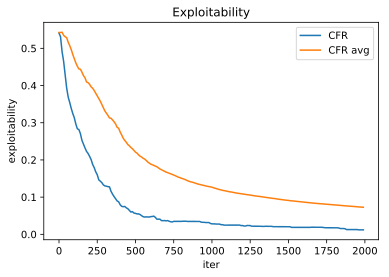

In [26]:
record_step = len(cfr_exp_list)
plt.plot(np.arange(record_step) * 10, cfr_exp_list, label="CFR")
plt.plot(np.arange(record_step) * 10, cfr_exp_avg_list, label="CFR avg")

plt.title("Exploitability")
plt.ylabel("exploitability")
plt.xlabel("iter")
plt.legend()
plt.show()

In [27]:
# Use CFR+ on Leduc
print("Now running CFR+ ...")

game = CFRGame(OneCardPoker.create_game(100))
cfrp_exp_list = []

num_iters = 2000

# regrets is a dictionary where the keys are the information sets and values
# are dictionaries from actions available in that information set to the
# counterfactual regret for not playing that action in that information set.
# Since information sets encode the player, we only require one dictionary.
regrets = dict()

# Similarly, action_counts is a dictionary with keys the information sets
# and values dictionaries from actions to action counts.
action_counts = dict()

# Strategy_t holds the strategy at time t; similarly strategy_t_1 holds the
# strategy at time t + 1.
strategy_t = dict()
strategy_t_1 = dict()

# Each information set is uniquely identified with an action tuple.
for t in tqdm(range(num_iters)):
    for i in [1, 2]:
        cfr_recursive(game, game.game.root, i, t, 1.0, 1.0, regrets,
                      action_counts, strategy_t, strategy_t_1, cfr_plus=True)

    # Update strategy_t to equal strategy_t_1. We update strategy_t_1 inside
    # cfr_recursive.  We take a copy because we update it inside
    # cfr_recursive, and want to hold on to strategy_t_1 separately to
    # compare.
    strategy_t = strategy_t_1.copy()

    if t % 10 == 0:
        # We also compute the best response to the current strategy.
        complete_strategy = game.game.complete_strategy_uniformly(strategy_t, verbose=False)
        exploitability = best_response.compute_exploitability(game.game, complete_strategy)
        cfrp_exp_list.append(exploitability)

Now running CFR+ ...


100%|██████████| 2000/2000 [00:39<00:00, 50.99it/s]


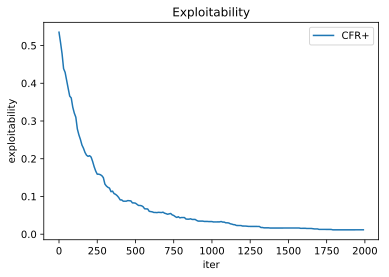

In [28]:
record_step = len(cfrp_exp_list)
plt.plot(np.arange(record_step) * 10, cfrp_exp_list, label="CFR+")

plt.title("Exploitability")
plt.ylabel("exploitability")
plt.xlabel("iter")
plt.legend()
plt.show()

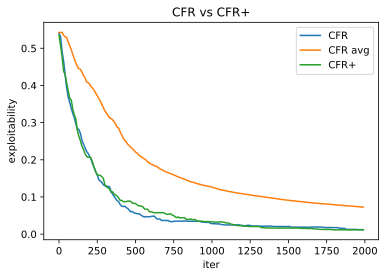

In [30]:
record_step = len(cfrp_exp_list)
assert(len(cfr_exp_list) == len(cfrp_exp_list))
plt.plot(np.arange(record_step) * 10, cfr_exp_list, label="CFR")
plt.plot(np.arange(record_step) * 10, cfr_exp_avg_list, label="CFR avg")
plt.plot(np.arange(record_step) * 10, cfrp_exp_list, label="CFR+")

plt.title("CFR vs CFR+")
plt.ylabel("exploitability")
plt.xlabel("iter")
plt.legend()
plt.show()